In [71]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


class Helper():

    @staticmethod
    def mse(y):
        return mean_squared_error(y, [np.mean(y)] * len(y))

    @staticmethod
    def mae(y):
        return mean_absolute_error(y, [np.mean(y)] * len(y))

class Node():

    def __init__(self, data, parent=None, criterion='mse'):
        self.data = data
        self.value = np.mean(data[:, -1])

        if criterion == 'mse':
            self.error = Helper.mse(data[:, -1])
        else:
            self.error = Helper.mae(data[:, -1])

        self.split_feat_idx = None
        self.split_feat_value = None

        self.left = None
        self.right = None
        self.parent = parent


class Tree():

    def __init__(self, data, criterion='mse', error_thres=0.1, split_fold_n=10, weighted=False):
        self.root = Node(data, criterion=criterion)
        self.current_node = self.root
        self.criterion = criterion
        self.error_thres = error_thres
        self.split_fold_n = split_fold_n
        self.weighted = weighted


    def split(self):
        current_data = self.current_node.data
        current_error = self.current_node.error

        current_error_gain = 0
        current_split_value = 0
        current_split_pos = [0, 0]

        # loop each column of features to search for split position
        for i in range(current_data.shape[1] - 1):

            current_data = current_data[current_data[:, i].argsort()]
            current_feature = current_data[:, i]
            current_y = current_data[:, -1]

            self.split_fold_n = len(current_feature)  # maybe too slow
            interval = int(len(current_feature) / self.split_fold_n)

            for j in range(1, self.split_fold_n):
                split_pos = j * interval

                if self.criterion == 'mse':
                    split_error0, split_error1 = Helper.mse(current_y[: split_pos]), Helper.mse(current_y[split_pos:])
                else:
                    split_error0, split_error1 = Helper.mae(current_y[: split_pos]), Helper.mae(current_y[split_pos:])
                
                if self.weighted:
                    error_gain = current_error - split_error0 * split_pos / len(current_y) - split_error1 * (len(current_y) - split_pos) / len(current_y)
                else:
                    error_gain = current_error - split_error0 - split_error1
                
                if error_gain > current_error_gain:
                    current_split_pos = [i, split_pos]
                    current_split_value = current_feature[split_pos]
                    current_error_gain = error_gain

        # cannot find a split position by error gain
        if current_error_gain == 0:
            return False

        # split
        self.current_node.split_feat_idx = current_split_pos[0]
        self.current_node.split_feat_value = current_split_value

        current_data = current_data[current_data[:, current_split_pos[0]].argsort()]
        split_data0, split_data1 = current_data[: current_split_pos[1]], current_data[current_split_pos[1]:]

        node0 = Node(data=split_data0, parent=self.current_node, criterion=self.criterion)
        node1 = Node(data=split_data1, parent=self.current_node, criterion=self.criterion)

        self.current_node.left = node0
        self.current_node.right = node1

        return True

    def check_split(self):
        if len(self.current_node.data) == 1:
            return False

        if self.current_node.error < self.error_thres:
            return False

        current_node_y = self.current_node.data[:, -1]

        if len(current_node_y[current_node_y == current_node_y[0]]) == len(current_node_y):
            return False

        return True

    def fit(self):

        if not self.check_split():
            return

        if not self.split():
            return

        for self.current_node in [self.current_node.left, self.current_node.right]:
            self.fit()

        self.current_node = self.root

    def predict(self, x):

        # leaf node
        if self.current_node.split_feat_idx is None:
            return self.current_node.value

        feat_idx, feat_value = self.current_node.split_feat_idx, self.current_node.split_feat_value

        self.current_node = self.current_node.left if x[feat_idx] < feat_value else self.current_node.right

        return self.predict(x)

    def prune(self):
        pass


if __name__ == '__main__':
    rng = np.random.RandomState(1)
    X = np.sort(5 * rng.rand(80, 1), axis=0)
    y = np.sin(X).ravel()
    y[::5] += 3 * (0.5 - rng.rand(16))
    y = y.reshape(-1, 1)
    data = np.hstack((X, y))

    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    
    tree = Tree(data, criterion='mse', error_thres=0.001)
    tree.fit()
    
    preds = []
    for i, x in enumerate(X_test):
        tree.current_node = tree.root
        pred = tree.predict(x)
        preds.append(pred)
        
    tree = Tree(data, criterion='mse', error_thres=0.001, weighted=True)
    tree.fit()
    
    preds_w = []
    for i, x in enumerate(X_test):
        tree.current_node = tree.root
        pred = tree.predict(x)
        preds_w.append(pred)
    

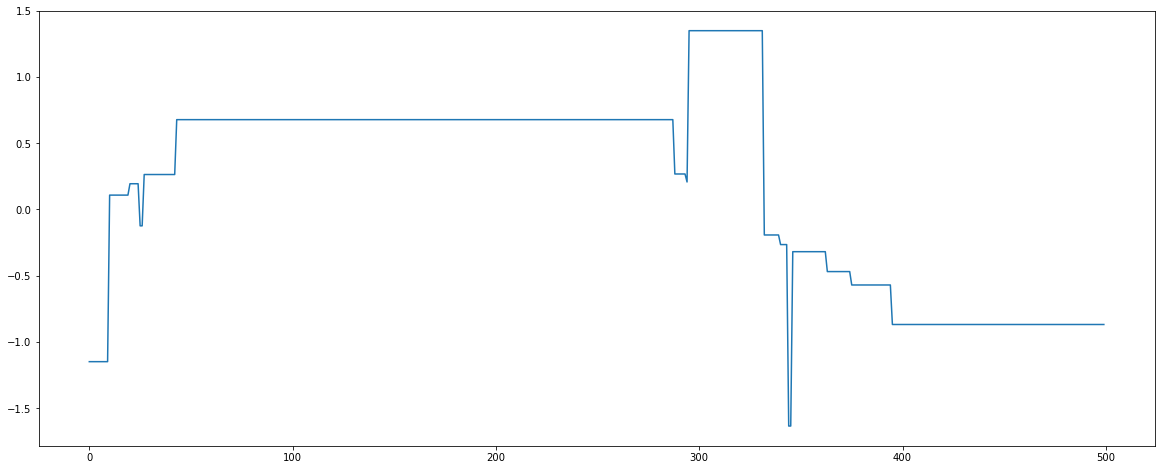

In [72]:
plt.figure(figsize=(20, 8))
plt.plot(preds)

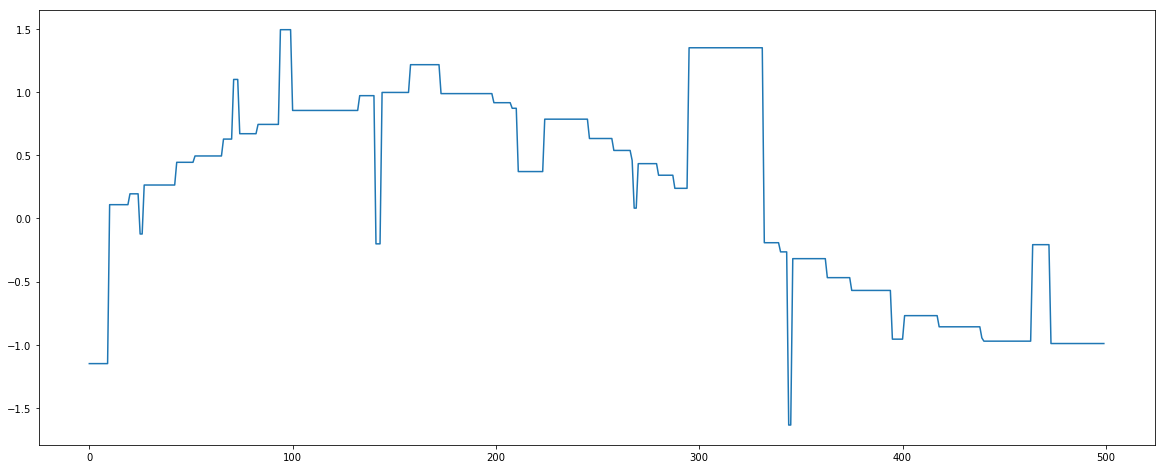

In [73]:
plt.figure(figsize=(20, 8))
plt.plot(preds_w)

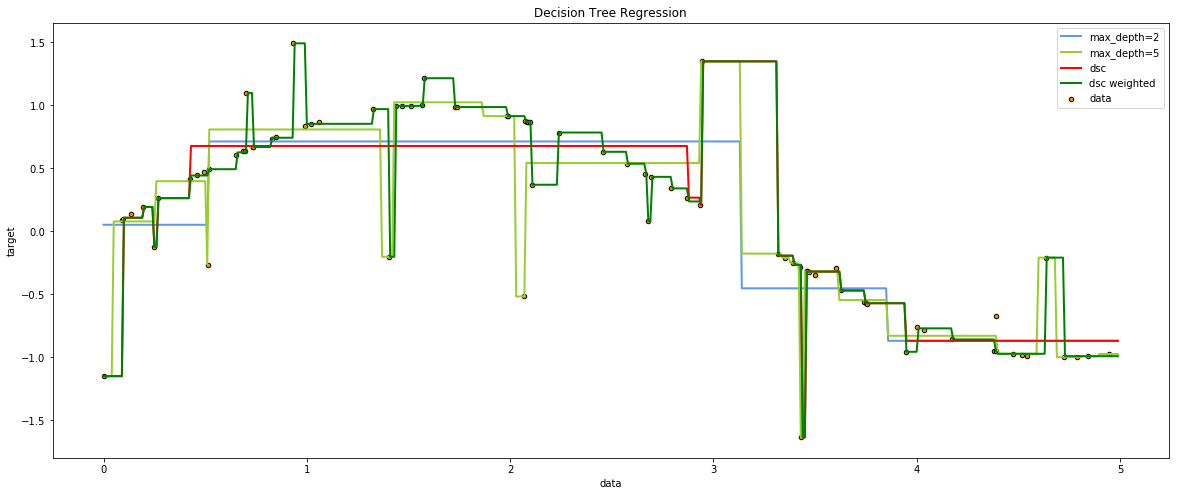

In [74]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

%matplotlib inline

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure(figsize=(20, 8))

plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")

plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.plot(X_test, preds, color="red", label="dsc", linewidth=2)
plt.plot(X_test, preds_w, color="green", label="dsc weighted", linewidth=2)

plt.xlabel("data")
plt.ylabel("target")

plt.title("Decision Tree Regression")

plt.legend()

plt.show()

In [53]:
len(X)

80